# A/B-тестирование

### Постановка задачи

Даны результаты теста и несколько датасетов.

Требуется проверить:

- пересечение тестовой аудитории с конкурирующим тестом,
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

### Описание данных

Календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

Пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

Действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

Таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

### Этапы выполнения.

- Ознакомление с данными
- Исследовательский анализ данных
- Оценка результатов A/B-тестирования
- Выводы.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from IPython.core.display import display, HTML
pd.set_option("display.max_colwidth", 120)
# На всю ширину экрана
display(HTML("<style>.container { width:95% !important; }</style>"))
from pylab import rcParams
rcParams['figure.figsize'] = 12, 5
from scipy import stats as st
import numpy as np
import math as mth

<div style="border:solid green 2px; padding: 20px">
    
Исследуем данные.  
**Загружаем календарь маркетинговых событий.**
</div>

In [2]:
df = pd.read_csv('ab_project_marketing_events.csv')
df.sort_values(by = 'start_dt')

,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


**Вывод**  
Время проведения теста пересекается с `Christmas&New Year Promo	` и с празднованием Нового года значит, условия проведения А/В теста заданы не корректно.  
Лучшим решением будет признать тест не состоявшимся.  
Но вообще-то можно посмотреть, что получилось, и ивлечь какие-то инсайты на будущее для себя и для проведения новых тестов.

<div style="border:solid green 2px; padding: 20px">
    
**Загружаем данные о пользователях**, зарегистрировавшиеся с 7 по 21 декабря 2020 года.
</div>

In [3]:
df_users = pd.read_csv('final_ab_new_users.csv', parse_dates = ['first_date'])
df_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Имеем 61 733 строки c указанием даты регистрации пользователя, региона и устройства.

In [4]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null datetime64[ns]
region        61733 non-null object
device        61733 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


In [5]:
print('Уникльных пользователей: ', df_users.user_id.nunique())

Уникльных пользователей:  61733


Значит дубликатов нет.  
Смотрим на даты регистрации и их распределение.

In [6]:
df_users.first_date.describe()

count                   61733
unique                     17
top       2020-12-21 00:00:00
freq                     6290
first     2020-12-07 00:00:00
last      2020-12-23 00:00:00
Name: first_date, dtype: object

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



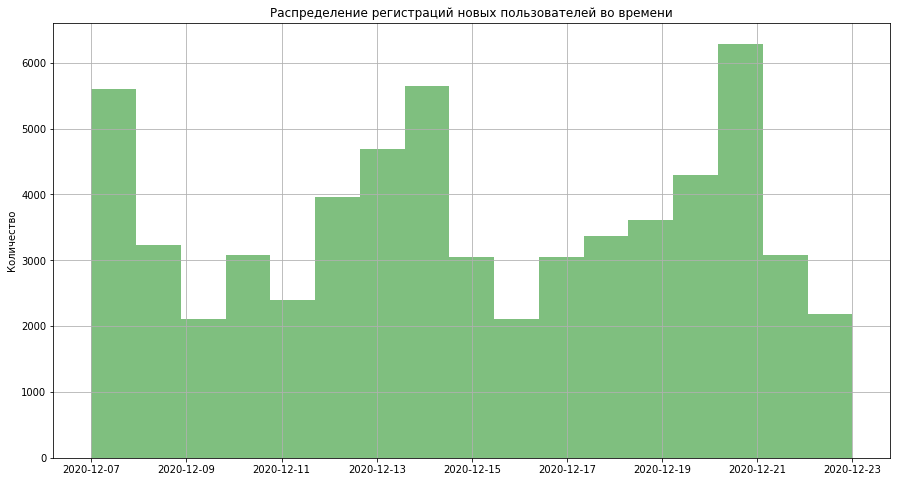

In [7]:
df_users.first_date.hist(figsize = (15, 8), bins = df_users.first_date.nunique(), color = 'g', alpha = .5)
plt.title('Распределение регистраций новых пользователей во времени')
plt.ylabel('Количество')
plt.show()

Хотя по ТЗ остановка набора новых пользователей -- 21.12.20, видим в датасете более 5000 пользователей зарегистриврованных 22.12.20 - 23.12.20 
Их надо исключить т.к. ожидаемый эффект мы расчитываем за 14 дней с момента регистрации, а эти пользователи к моменту окончания теста зарегистрированы менее 14 дней.  
Кроме того, по распределению можно заметить понижение числа регистраций в среды (9.12 и 16.12) и повышение количества регистраций по понедельникам.

In [8]:
# Делаем срез данных для исключения зарегистрировавшихся после 21.12
df_users = df_users.query('first_date < "22.12.2020"')

Посмотрим на регионы.

In [9]:
df_users.groupby('region').count()

,user_id,first_date,device
region,,,
APAC,2883,2883,2883
CIS,2900,2900,2900
EU,42340,42340,42340
N.America,8347,8347,8347


По регионам пользователи распределены не равномерно -- в Европе наших клиентов больше чем 3-х других регионах вместе взятых.  
На собственно и интересует результат изменений на европейской аудитории.

In [10]:
df_users.groupby(['region', 'device']).agg({'user_id': 'count'}).T

region     APAC                      CIS                       EU        \
device  Android  Mac   PC iPhone Android  Mac   PC iPhone Android   Mac   
user_id    1295  286  731    571    1298  282  710    610   18828  4161   

region                N.America                    
device      PC iPhone   Android  Mac    PC iPhone  
user_id  10760   8591      3740  793  2109   1705

Пропорции по используемым устройствам во всех регионах примерно одинаковые.  
Android  - бесспорный лидер.

<div style="border:solid green 2px; padding: 20px">
    
**Загрузим и исследуем данные о действиях пользователей** с 07.12.20 по 04.01.2021
</div>

In [11]:
df_ev = pd.read_csv('final_ab_events.csv', parse_dates = ['event_dt'])
df_ev.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [12]:
df_ev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null datetime64[ns]
event_name    440317 non-null object
details       62740 non-null float64
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


Есть пропущенные значения в колонке `details`. Здесь хранится стоимость покупок, соответственно заполнены только события `purchase`

In [13]:
print('Количесто "purchase" в датафрейме - ', df_ev.query('event_name == "purchase"')['details'].count())
print('Количесто пропущенных значений в колонке "details" напротив "purchase" - ', \
      df_ev.query('event_name == "purchase"')['details'].isna().sum())

Количесто "purchase" в датафрейме -  62740
Количесто пропущенных значений в колонке "details" напротив "purchase" -  0


Так и есть - напротив событий `purchase` нет ни одного пропущенного значения в `details`  
Проверяем на дубликаты.

In [14]:
print('Количесто дубликатов в датафрейме - ', df_ev.duplicated().sum())

Количесто дубликатов в датафрейме -  0


Какие у нас есть события?

In [15]:
df_ev.event_name.value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

Уже можно предположить, как будет выглядеть продуктовая воронка. Просмотров корзины немного меньше чем покупок, видимо функционал позволяет производить покупки не заходя в корзину. Потом можно будет посмотреть соотношение количества заходов в корзину и покупок в разных группах теста.

Посмотрим на даты событий

In [16]:
df_ev.event_dt.describe()

count                  440317
unique                 267268
top       2020-12-23 02:37:24
freq                       10
first     2020-12-07 00:00:33
last      2020-12-30 23:36:33
Name: event_dt, dtype: object

Получается по факту тест остановился 30.12.20. Значит НГ мы не затронули ) Только предновогоднюю лихорадку )  
Тогда надо отбрасывать не только зарегистрированных 22-23.12, а всех, кто зарегистрировался после 17.12, чтобы lifetime был не менее 14 дней.

Посмотрим, как распределены события во времени

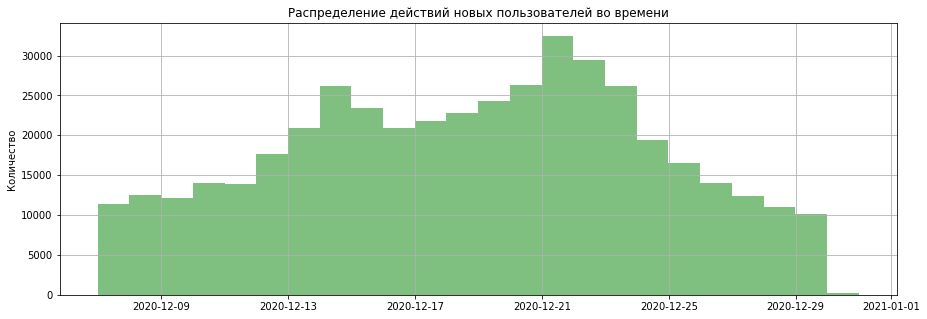

In [17]:
df_ev.event_dt.hist(bins = 24, figsize = (15, 5), color = 'g', alpha = .5)
plt.title('Распределение действий новых пользователей во времени')
plt.ylabel('Количество')
plt.show()

Отмечаем повышенное количество событий по понедельникам - так же как с регистрациями.  
Надо проверить сколько событий произошло 30.12.20 - подозрительно низкий столбик )

In [18]:
print('Количество событий 30.12.2020  - ', df_ev.query('event_dt > "29.12.2020 23:59:59"')['user_id'].count())

Количество событий 30.12.2020  -  89


Эту дату тоже исключим из теста. Тогда и дату последней регистрации уменьшаем еще на 1 день.

In [19]:
# Убираем события 30.12.20
df_ev = df_ev.query('event_dt < "30.12.2020"')
# Отсекаем всех, кто зарегистрировался после 16.12.2020
df_users = df_users.query('first_date < "17.12.2020"')

Сколько уникальных пользователей совершали действия на сайте согласно данным о событиях?

In [20]:
print('Количество уникальных пользователей в df_ev  - ', df_ev.user_id.nunique())

Количество уникальных пользователей в df_ev  -  58703


Получилось меньше, чем зарегистрировалось, не все совершали действия на сайте (или в приложении)  
Посмотрим что с ценами.

In [21]:
df_ev.details.value_counts()

4.99      46353
9.99       9526
99.99      5629
499.99     1217
Name: details, dtype: int64

Все по 5, 10, 100 и 500 $ -- Может у нас продается подписка на что-то ?  
Для объединения датафреймов будет удобней если заполним NaN.

In [22]:
df_ev = df_ev.fillna(0)

<div style="border:solid green 2px; padding: 20px">
    
Прочитаем данные об **учаcтниках тестов**
</div>

In [23]:
df_ab = pd.read_csv('final_ab_participants.csv')
df_ab.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [24]:
df_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
user_id    18268 non-null object
group      18268 non-null object
ab_test    18268 non-null object
dtypes: object(3)
memory usage: 428.3+ KB


Имеем 18 268 записей. Пропусков нет.

In [25]:
# Проверяем на дубликаты
df_ab.duplicated().sum()

0

Дубликатов нет.  
Сколько уникальных пользователей?

In [26]:
df_ab.user_id.nunique()

16666

А пользователи есть повторяющиеся.  
Какие тесты у нас есть?

In [27]:
df_ab.ab_test.value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

Нас интересует только `recommender_system_test`, значит для нас есть 6701 запись.  
Проверяем есть ли в них пользователи попавшие в оба теста.

In [28]:
df_ab_test_group = df_ab.groupby('user_id')['ab_test'].count().reset_index()
double_test_users = df_ab_test_group.query('ab_test > 1')
double_test_users

,user_id,ab_test
2,001064FEAAB631A1,2
10,00341D8401F0F665,2
12,003B6786B4FF5B03,2
29,0082295A41A867B5,2
46,00E68F103C66C1F7,2
...,...,...
16638,FF7BE2897FC0380D,2
16644,FF9A81323FA67D6E,2
16652,FFC53FD45DDA5EE8,2
16662,FFED90241D04503F,2


Имеем 1602 пользователя, которые попали в оба теста.
Убираем их из датасета. 

In [29]:
df_ab_clean = df_ab.query('user_id not in @double_test_users.user_id')
len(df_ab_clean)

15064

Осталось 15 064 записи. Отфильтровываем наш тест - `recommender_system_test`

In [30]:
df_ab_clean = df_ab_clean.query('ab_test == "recommender_system_test"')
df_ab_clean

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
5,4FF2998A348C484F,A,recommender_system_test
6,7473E0943673C09E,A,recommender_system_test
...,...,...,...
6696,053FB26D6D49EDDC,A,recommender_system_test
6697,9D263B8EF15CF188,B,recommender_system_test
6698,F2FBBA33F37DEC46,A,recommender_system_test
6699,29C92313A98B1176,B,recommender_system_test


In [31]:
# На всякий случай еще раз посмотрим 
df_ab_clean.groupby('user_id')['group'].count().value_counts()

1    5099
Name: group, dtype: int64

Объединяем датафреймы, чтоб иметь общую картину.

In [32]:
df_users_participants = df_ab_clean.filter(['user_id', 'group']).merge(df_users, on = 'user_id', how = 'left')
df_users_participants

,user_id,group,first_date,region,device
0,D1ABA3E2887B6A73,A,2020-12-07,EU,PC
1,A7A3664BD6242119,A,NaT,NaN,NaN
2,482F14783456D21B,B,2020-12-14,EU,PC
3,4FF2998A348C484F,A,NaT,NaN,NaN
4,7473E0943673C09E,A,2020-12-16,EU,iPhone
...,...,...,...,...,...
5094,053FB26D6D49EDDC,A,2020-12-10,N.America,Android
5095,9D263B8EF15CF188,B,2020-12-16,N.America,Mac
5096,F2FBBA33F37DEC46,A,NaT,NaN,NaN
5097,29C92313A98B1176,B,2020-12-07,APAC,Android


Появились пропущенные значения, потому, что ранее я убрал пользователей зарегистрированных после 16.12  
Добавляем информацию о действиях и удаляем пропуски.

In [33]:
df = df_users_participants.merge(df_ev, on = 'user_id')
df = df.dropna()
display(df.sample(10))
display(len(df))

,user_id,group,first_date,region,device,event_dt,event_name,details
2068,269363BBED2CB3CB,A,2020-12-15,EU,PC,2020-12-15 01:08:34,login,0.00
15855,3175038D993E72DA,A,2020-12-16,EU,iPhone,2020-12-20 11:56:15,product_page,0.00
15265,C48127E2FA8D4F18,B,2020-12-07,EU,iPhone,2020-12-19 06:32:23,login,0.00
18344,DD9A0E2A3E6E87B4,B,2020-12-08,CIS,Android,2020-12-18 16:58:41,purchase,9.99
170,DA84B03F1D02D13E,B,2020-12-16,EU,PC,2020-12-24 00:05:04,product_cart,0.00
10001,49EA242586C87836,B,2020-12-07,EU,iPhone,2020-12-09 15:39:49,product_page,0.00
17179,CD0AECDFED70559A,A,2020-12-11,EU,PC,2020-12-18 12:09:45,login,0.00
18684,F9DEDF376FFBDD1E,A,2020-12-14,N.America,Android,2020-12-17 07:11:03,login,0.00
5926,9745CE1D5B111CB1,A,2020-12-14,EU,iPhone,2020-12-19 13:37:39,login,0.00
264,8A25966EC4F23ECA,A,2020-12-15,EU,PC,2020-12-15 05:31:23,product_page,0.00


10491

Осталось 10 491 строка,  
теперь убираем всех, кто не из Европы.

In [34]:
df = df.query('region == "EU"')
print('Количество записей в датафрейме - ', len(df))
print('Количество уникальных пользователей для теста - ', df.user_id.nunique())

Количество записей в датафрейме -  9778
Количество уникальных пользователей для теста -  1419


Поскольку нам нужно оценить ожидаемый эффект за 14 дней, следует отбросить события совершенные пользователями позже 14-ти дней от регистрации.  
Рассчитаем в отдельной колонке дату 14го дня после регистрации пользователя.

In [35]:
df['last_date'] = df['first_date'] + pd.Timedelta(days = 14)
df.sample(10)

,user_id,group,first_date,region,device,event_dt,event_name,details,last_date
10566,900BB01307F50F4A,A,2020-12-08,EU,Android,2020-12-08 01:23:56,purchase,99.99,2020-12-22
13774,C24D35CD1D858C2C,A,2020-12-14,EU,Android,2020-12-14 10:11:53,product_page,0.00,2020-12-28
11775,C93A37ECF99BFDE0,A,2020-12-09,EU,iPhone,2020-12-20 22:44:21,purchase,4.99,2020-12-23
3548,22AD7C5B0BF83D87,A,2020-12-08,EU,Android,2020-12-08 22:23:35,login,0.00,2020-12-22
13468,1BFEE479308EFF44,A,2020-12-14,EU,Mac,2020-12-17 10:49:43,login,0.00,2020-12-28
15885,5495462E39AD0771,A,2020-12-16,EU,Android,2020-12-19 11:37:17,login,0.00,2020-12-30
14352,2FD99D64C3608961,A,2020-12-11,EU,Android,2020-12-11 07:10:14,login,0.00,2020-12-25
3199,DC241C9F0E1F9EE2,A,2020-12-08,EU,PC,2020-12-09 08:16:45,product_cart,0.00,2020-12-22
10842,77FC0E20AEAC1506,A,2020-12-07,EU,Android,2020-12-13 00:25:05,login,0.00,2020-12-21
14683,4B4A29DE0792264D,A,2020-12-09,EU,Android,2020-12-19 10:27:53,product_page,0.00,2020-12-23


Оставим только те строки где дата события меньше "последней" даты.

In [36]:
df = df.query('event_dt < last_date')
df

,user_id,group,first_date,region,device,event_dt,event_name,details,last_date
0,D1ABA3E2887B6A73,A,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-21
2,D1ABA3E2887B6A73,A,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,0.00,2020-12-21
4,D1ABA3E2887B6A73,A,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,0.00,2020-12-21
6,D1ABA3E2887B6A73,A,2020-12-07,EU,PC,2020-12-07 14:43:27,login,0.00,2020-12-21
26,7473E0943673C09E,A,2020-12-16,EU,iPhone,2020-12-16 10:31:31,product_page,0.00,2020-12-30
...,...,...,...,...,...,...,...,...,...
17519,80712ED4EA1B52A5,A,2020-12-14,EU,Android,2020-12-15 20:10:06,product_page,0.00,2020-12-28
17520,80712ED4EA1B52A5,A,2020-12-14,EU,Android,2020-12-20 20:01:34,product_page,0.00,2020-12-28
17521,80712ED4EA1B52A5,A,2020-12-14,EU,Android,2020-12-14 05:48:50,login,0.00,2020-12-28
17522,80712ED4EA1B52A5,A,2020-12-14,EU,Android,2020-12-15 20:10:03,login,0.00,2020-12-28


<div style="border:solid green 2px; padding: 20px">

**Считаю, что для проведения статистических тестов датасет готов**   
Рассмотрим соотношение количества пользователей в группах.

Рассмотрим количество пользователей в группах

In [37]:
df.groupby('group')['user_id'].nunique()

group
A    969
B    450
Name: user_id, dtype: int64

Неравномерное распределение пользователей.  
Для проведения А/В теста желательно одинаковое количество участников в группах. Но это правило носит больше рекомендательных характер. Будем оценивать результаты по этим данным.

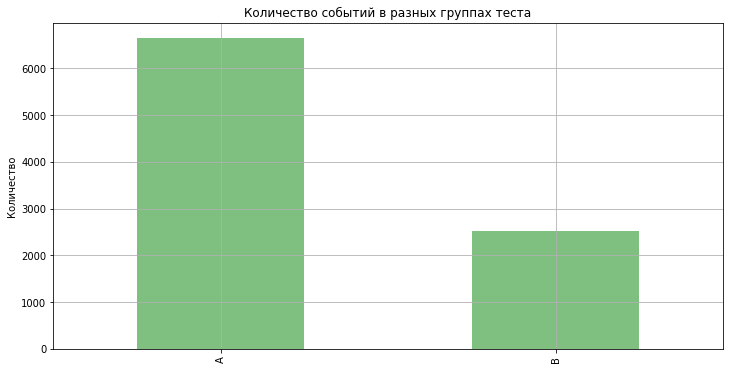

In [38]:
df.group.value_counts().plot(kind='bar', color = 'g', alpha = .5, figsize = (12, 6), grid = True)
plt.title('Количество событий в разных группах теста')
plt.ylabel('Количество')
plt.show()

Закономерно количество событий в группе А более чем в 2 раза превышает количество в группе В  
Сколько событий разного типа во всех данных?

In [39]:
for x in df.event_name.unique():
    print('Событий типа', x, '\n', len(df.query('event_name == @x')))

Событий типа purchase 
 1166
Событий типа product_cart 
 1265
Событий типа product_page 
 2556
Событий типа login 
 4185


Посмотрим на количество событий на одного пользователя. Сначала на распределение на диаграмме.

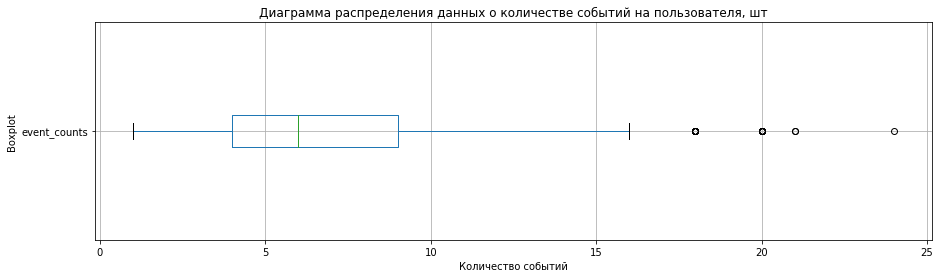

In [40]:
df.groupby('user_id').agg(event_counts = ('event_dt', 'count')).reset_index().boxplot('event_counts', vert = 0, figsize = (15, 4))
plt.title('Диаграмма распределения данных о количестве событий на пользователя, шт')
plt.xlabel('Количество событий')
plt.ylabel('Boxplot')
plt.show()

Выбросов не много среднее-арифметическое от медианы сильно отличаться не будет.

In [41]:
print('Среднее значение количества событий на пользователя - ',\
      df.groupby('user_id').agg(event_counts = ('event_dt', 'count')).reset_index()['event_counts'].mean().round(2))
print('Медианное значение количества событий на пользователя - ',\
      df.groupby('user_id').agg(event_counts = ('event_dt', 'count')).reset_index()['event_counts'].median())

Среднее значение количества событий на пользователя -  6.46
Медианное значение количества событий на пользователя -  6.0


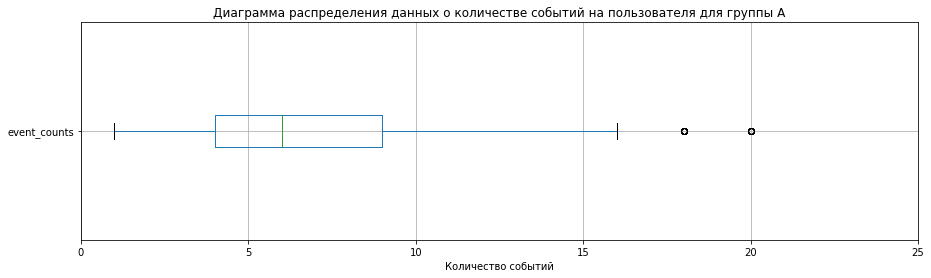

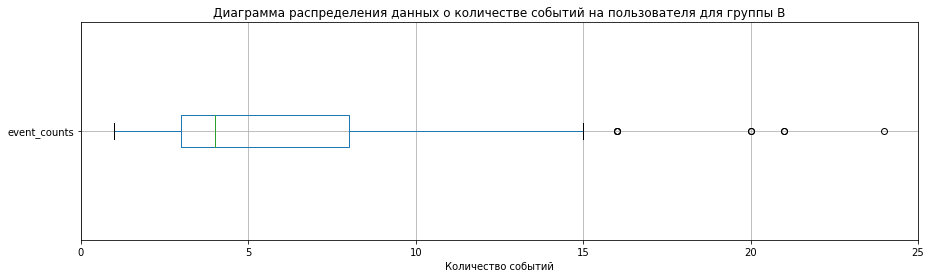

In [42]:
for x in df.group.unique():
    df.query('group == @x').groupby('user_id').agg(event_counts = ('event_dt', 'count')).reset_index().boxplot('event_counts', vert = 0, figsize = (15, 4))
    plt.xlim(0, 25)
    plt.title('Диаграмма распределения данных о количестве событий на пользователя для группы ' + x)
    plt.xlabel('Количество событий')
    plt.show()

Средние значения количества событий для групп теста уже отличаются - в "А" медиана так и остается - 6, а для "В" 
она равна 4.  
Ранее мы оценили распределение всех событий по времени, теперь рассмотрим то же распределение для нашей выборки.  
Количество столбцов = количеству дней теста

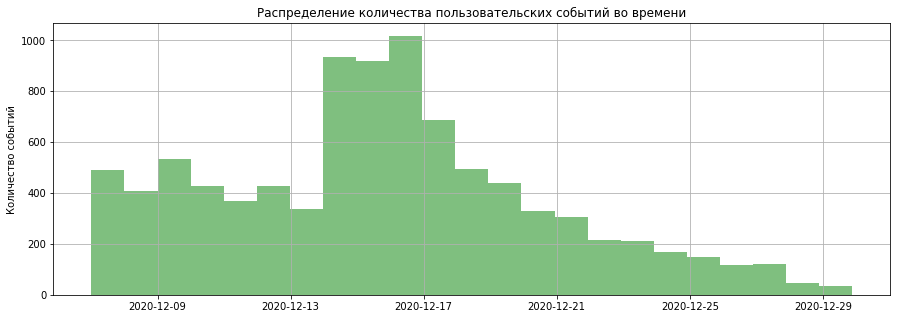

In [43]:
df.event_dt.hist(bins = 23, figsize = (15, 5), color = 'g', alpha = .5)
plt.title('Распределение количества пользовательских событий во времени')
plt.ylabel('Количество событий')
plt.show()

Пик активности пришелся на середину теста, после 17.12.20 активность пользователей планомерно падала.  
Посмотрим на эти графики с раделением по группам. Количество столбцов = количеству дней теста

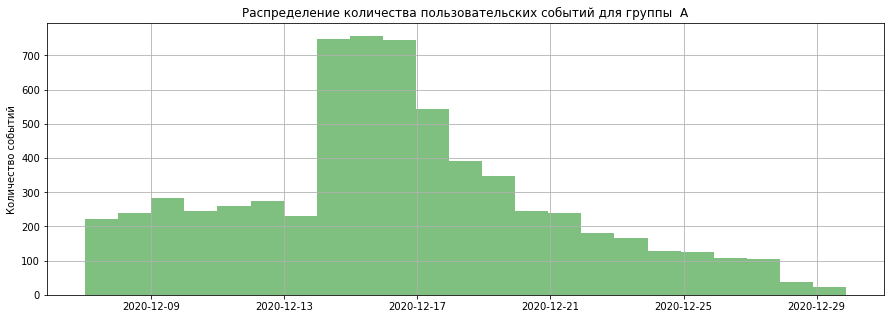

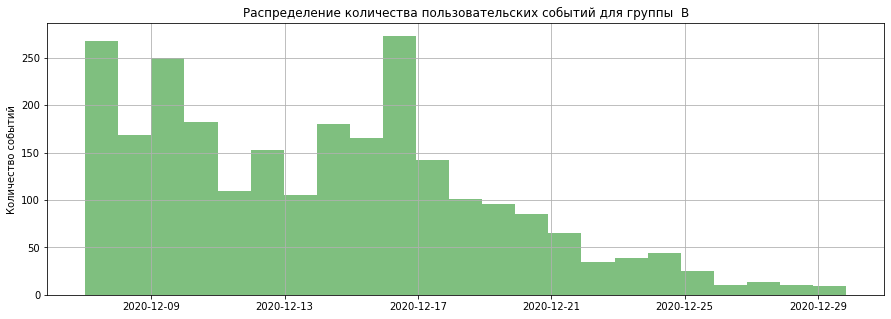

In [44]:
for x in df.group.unique():
    df.query('group == @x').event_dt.hist(bins = 23, figsize = (15, 5), color = 'g', alpha = .5)
    plt.title('Распределение количества пользовательских событий для группы  ' + x)
    plt.ylabel('Количество событий')
    plt.show()

Падение пользовательского интереса наблюдается в обеих группах, пик активности отмеченный на общем графике явно выражен по группе "А". В начале теста количество событий в группе "В" отстает не сильно, а к экватору теста "А" выбивается в лидеры.

<div style="border:solid green 2px; padding: 20px">

Рассчитаем количество пользователей совершивших определенные действия.

In [45]:
users_by_events = df.groupby('event_name').agg(unique_users = ('user_id', 'nunique')).\
                                            reset_index().sort_values('unique_users', ascending = 0)
users_by_events['users_rate'] = (users_by_events['unique_users'] / df['user_id'].nunique() * 100).round(2)
users_by_events

,event_name,unique_users,users_rate
0,login,1418,99.93
2,product_page,876,61.73
1,product_cart,425,29.95
3,purchase,410,28.89


Почти 100% уникальных пользователей во время проведения теста зашли насайт.  
Конверсия в просмотр товара из входа на сайт - 62% (вообще это пропорция от общего числа пользователей, но поскольку все зашли, можно считать это конверсией из входа на сайт)  
Конверсия из входа на сайт в корзину - 30%  
И почти 29% конверсии из общего количества пользователей в покупку. Цифра просто космическая )  
Поскольку пояснений о том как должна выглядеть воронка у нас нет, предположим, что последовательность именно такая - по количеству событий - login, product_page (просмотр товара с отправкой его в корзину), product_cart (просмотр корзины), purchase (покупка).  
Но есть предположение, что у пользователя есть возможность покупки без захода в корзину, тогда конверсия из корзины в покупку, которая сейчас почти 100%, будет ниже.  

<div style="border:solid green 2px; padding: 20px">
Построим воронку событий.

In [1]:
# fig = go.Figure(go.Funnel(
#     y = users_by_events['event_name'],
#     x = users_by_events['unique_users']))
# fig.update_layout(
#     title={'text': "Воронка событий.",
#            'y':0.9,
#            'x':0.5,
#            'xanchor': 'center',
#            'yanchor': 'top'},
#     font=dict(
#         family="Courier New, monospace",
#         size=16,
#         color="black"),
#     legend=dict(
#     yanchor="top",
#     y=0.99,
#     xanchor="left",
#     x=0.8))
# fig.show()

Конверсии относительно предыдущего шага следующие:  
- 62% в просмотр товара из входа на сайт
- 48.5% из просмотра товара в корзину
- 96.5% из корзины в покупку


Не забываем, что последняя цифра может быть не актуальной, если у пользователя есть возможность купить не заходя в корзину.

<div style="border:solid green 2px; padding: 20px">
    
Для ответа на вопрос **есть ли ожидаемый эффект в виде улучшения метрик на 10%** построим сводную таблицу.

In [47]:
tests_groups = df.pivot_table(index = 'group', columns = 'event_name', values = 'user_id', aggfunc = 'nunique').reset_index()
# Рассчитываем количество уникальных пользователей в каждой группе теста.
tests_users = df.groupby('group').agg(total_users = ('user_id', 'nunique')).reset_index()
# Добавляем информацию о количестве пользователей в сводную таблицу
tests_results = tests_users.merge(tests_groups)
tests_results

,group,total_users,login,product_cart,product_page,purchase
0,A,969,969,300,623,286
1,B,450,449,125,253,124


<div style="border:solid green 2px; padding: 20px">
Рассчитаем метрики, по которым будем оценивать в просмотр карточек товаров.

In [48]:
# Конверсия в просмотр товара
tests_results['product_page_ratio'] = (tests_results['product_page'] / tests_results['total_users'] * 100).round(2)
# Конверсия в просмотр корзины
tests_results['product_cart_ratio'] = (tests_results['product_cart'] / tests_results['total_users'] * 100).round(2)
# Конверсия в покупки
tests_results['purchase_ratio'] = (tests_results['purchase'] / tests_results['total_users'] * 100).round(2)

tests_results

,group,total_users,login,product_cart,product_page,purchase,product_page_ratio,product_cart_ratio,purchase_ratio
0,A,969,969,300,623,286,64.29,30.96,29.51
1,B,450,449,125,253,124,56.22,27.78,27.56


Конверсия в просмотр карточек товаров, конверсия в просмотр корзины в экспериментальной группе В меньше чем в контрольной группе А

In [49]:
AB_prod_page_ratio = tests_results.loc[1,'product_page_ratio'] / tests_results.loc[0,'product_page_ratio'] - 1
print('Kонверсия в просмотр карточки продукта в группе В упала по отношению к контрольной на {:.2%}'.format(abs(AB_prod_page_ratio)))

Kонверсия в просмотр карточки продукта в группе В упала по отношению к контрольной на 12.55%


In [50]:
AB_prod_cart_ratio = tests_results.loc[1,'product_cart_ratio'] / tests_results.loc[0,'product_cart_ratio'] - 1
print('Kонверсия в просмотр корзины в группе В упала по отношению к контрольной на {:.2%}'.format(abs(AB_prod_cart_ratio)))

Kонверсия в просмотр корзины в группе В упала по отношению к контрольной на 10.27%


In [51]:
AB_purchase_ratio = tests_results.loc[1,'purchase_ratio'] / tests_results.loc[0,'purchase_ratio'] - 1
print('Kонверсия в покупку в группе В упала по отношению к контрольной на {:.2%}'.format(abs(AB_purchase_ratio)))

Kонверсия в покупку в группе В упала по отношению к контрольной на 6.61%


Поскольку мы видим противоположный результат по отношению к предполагаемому, статистическое исследование не требуется.  
Но все-таки проверим действительно ли есть статистическая разница долей z-критерием.  
H0 - Доли пользователей увидевших тот или иной экран (совершивших событие) в каждой группе равны.  
H1 - Доли пользователей увидевших тот или иной экран (совершивших событие) в каждой группе не равны.

<div style="border:solid green 2px; padding: 20px">

Проверим наличие статистической разницы долей z-критерием.

In [52]:
def stat_hipo(success):
    '''Проверяет гипотезу об отсутствии статистических различий между 
    долями пользователей относительно общего количества пользователей
    между экспериментальными группами '''
    print('Событие', success)
    alpha = .05 # критический уровень статистической значимости
    successes = tests_results[success]
    trials = tests_results['total_users']
    experiment = tests_results['group']
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    # разница пропорций в датасетах
    difference = p1 - p2
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Для', experiment[0], 'и', experiment[1], 'p-значение: {:.5f}'.format(p_value))
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

In [53]:
for event in ['product_page', 'product_cart', 'purchase']:
    stat_hipo(event)
    print()

Событие product_page
Для A и B p-значение: 0.00360
Отвергаем нулевую гипотезу: между долями есть значимая разница

Событие product_cart
Для A и B p-значение: 0.22331
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие purchase
Для A и B p-значение: 0.44858
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



По результатам проверки имеем статистически значимую разницу конверсии в просмотр товара между группами теста.  
Но между группами нет статистически значимой разницы конверсий в просмотр корзины и в покупку.

### Выводы
Данные предоставлены в виде 4-х датасетов:  
календарь маркетинговых событий на 2020 год  
пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года  
действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года  
таблица участников тестов  

Результаты EDA:  
Основная масса покупателей из Европы.  
Из 4-х видов устройств самый распространенный для нашего магазина - Android.  
Имеем данные о 4-х видах пользовательских действий:  
Логин, просмотр товара, просмотр корзины, покупка.  

На протяжении всего срока проведения теста количество событий распределено не равномерно - 2 пика активности в середине и малая активность в начале и к концу.

Последний день, когда мы фиксируем пользовательскую активность был 29.12.20.  
Соответственно было сокращено количество зарегистрированных пользователей (по дате регистрации), чтобы привести в соответствие с ТЗ срок их "жизни" на сайте - 14 дней.  
Были обнаружены пользователи, которые оказались в тестовых группах сразу в двух тестах.  
В итоге из 61 733 новых зарегистрированных пользователей в тесте приняло участие 1 419.  
Среднее количество действий на уникльного пользователя - 6.   
По воронке событий ым увидели конверсию в покупку - 30% от общего количества пользователей.  

В процессе иследовательского анализа данных было выявлено:  
А/В тест проводился в предверии и во время праздников, во время действия промоакции, параллельно с другим тестом.   
Эти факты сразу ставят под большое сомнение результаты теста.  

Ожидаемый эффект (за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%) достигнут не был. Кроме того тестовая группа показала результаты даже хуже чем контрольная.  
Kонверсия в просмотр карточки продукта в группе В упала по отношению к контрольной на 12.55%  
Kонверсия в просмотр корзины в группе В упала по отношению к контрольной на 10.27%  
Kонверсия в покупку в группе В упала по отношению к контрольной на 6.61%  
 
Проверка статистической разницы долей Z-критерием показала наличие таковой между группами в конверсии в просмотр карточки товара и отсутствие в просмотр корзины и покупку.
